# BLU05 - Learning Notebook - Part 1 of 3 - Time Series Components

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = (16, 8)
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
seed(1)

from utils import load_electricity_consumption_series
from utils import load_airlines_series

%matplotlib inline

In the previous BLU, you learned fundamental concepts to start modelling time series, in this BLU you'll finally learn how to actually model them. For that, we're going to dive a bit deeper into their components using a very useful library: _statsmodels_.

As you may have come to realize, timeseries are sneaky things. Sometimes noise looks like a signal, and the signal looks like noise. 

A frequent problem with timeseries is answering the open, yet crucial question: _"is there any kind of signal here?"_ 

Various datasets are used in this BLU. We aimed to describe the data through the labels of the figures, but we admit that this may be a bit too light. Feel free to get a better understanding of the data by exploring the original data files (something which data scientists have to do 99.9% of the time). You might find some interesting stuff there :-)

The first thing to do, as always, is to ~~run a highly complex LSTM analysis on the deep learning blockchain~~ **plot the data**

In [2]:
airlines = load_airlines_series()

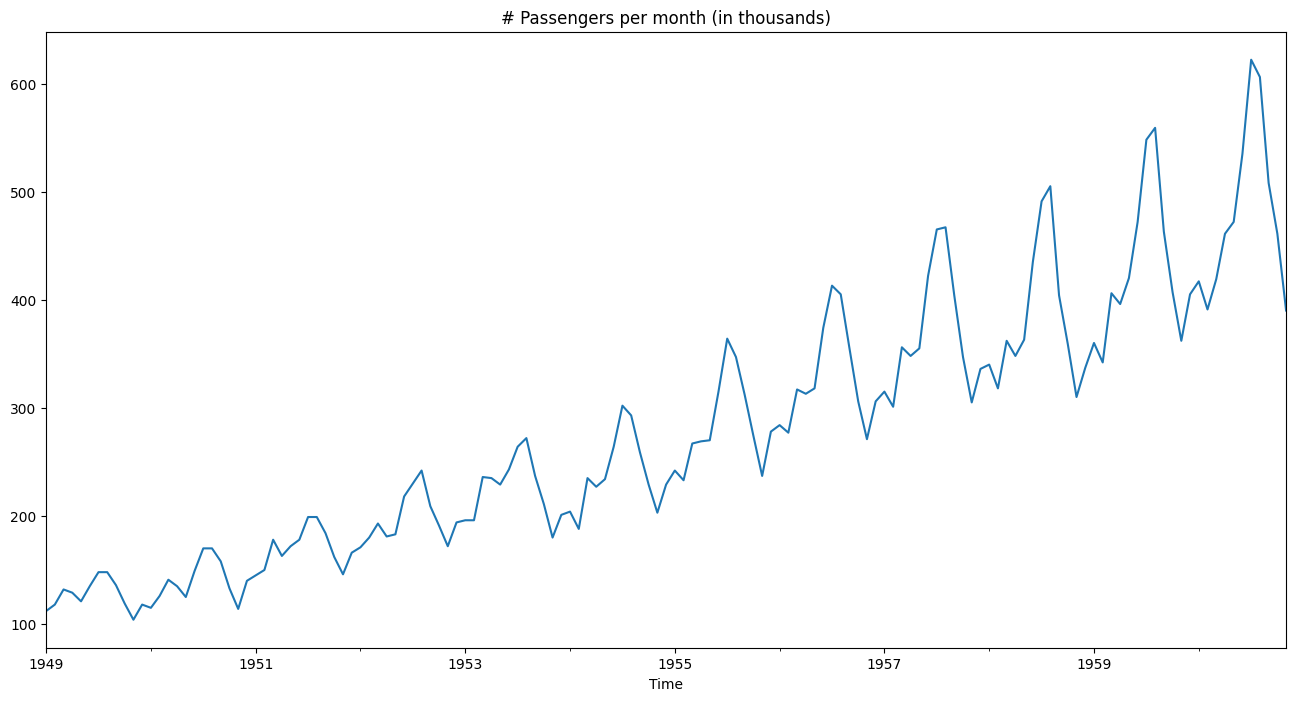

In [3]:
airlines.plot()
plt.xlabel("Time")
plt.title("# Passengers per month (in thousands)")
plt.show()

## 1. Seasonal Decomposition

In the previous BLU, you were introduced to the different components of a timeseries:  
- Trend (T)
- Cyclical (C)
- Seasonal (S)
- Irregular (I)

Additionally, we saw two ways of combining these components:
1. additive ($Y = T + C + S + I$)
1. multiplicative ($Y = T \cdot C \cdot S \cdot I$)

But...how do we know if our time series is additive or multiplicative? Citing [Hyndman & Athanasopoulos](https://otexts.org/fpp2/components.html)

> _The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate._

There are several ways to decompose a timeseries: using [moving averages](https://otexts.com/fpp2/moving-averages.html), [X11](https://otexts.org/fpp2/x11.html), [SEATS](https://otexts.org/fpp2/seats.html) and [STL](https://otexts.org/fpp2/stl.html). In this BLU, we will use the `seasonal_decompose` function from the [statsmodel](https://www.statsmodels.org/stable/index.html), a python module with a rich set of models, plots and validation procedures for time series.

We need to choose if we will use `model=additive` or `model=multiplicative`. In order to do that, we have to look at our time series and follow the Hyndman & Athanasopoulos guidelines that we read just before.

Looking back at the previous plot, it seems that the variance around the trend (remember the linear trend estimation?) is increasing throughout time. To verify this visually, let's calculate a rolling standard deviation using the `pandas.Series.rolling.std` and plot the result:

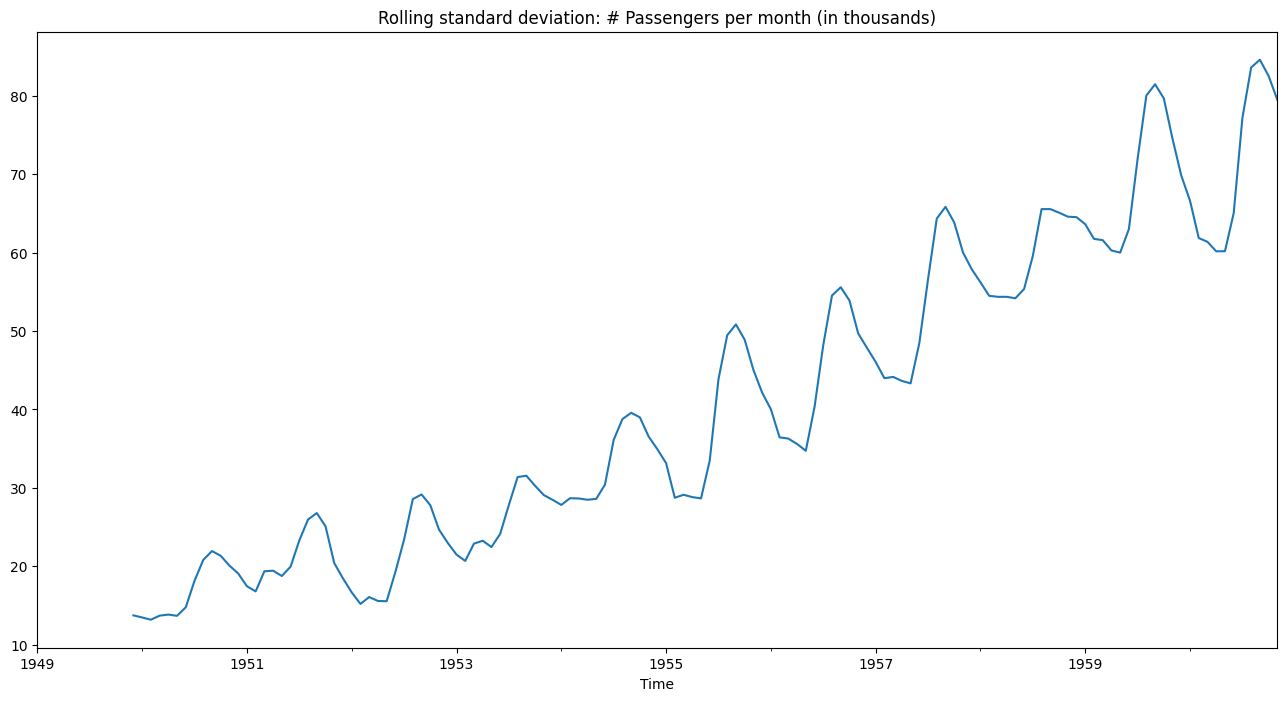

In [44]:
airlines.rolling(12).std().plot()
plt.xlabel("Time")
plt.title("Rolling standard deviation: # Passengers per month (in thousands)")
plt.show()

In [6]:
decomposition = seasonal_decompose(airlines, model="multiplicative")
decomposition

This object allows us to visualize and access the following components: 
* Trend-Cycle (spoiler alert: it combines the trend and the cycle)
* Seasonal
* Residuals (an alternative name for the Irregular; the leftovers from the decomposition)

statsmodel includes a function to plot all 3 components at once

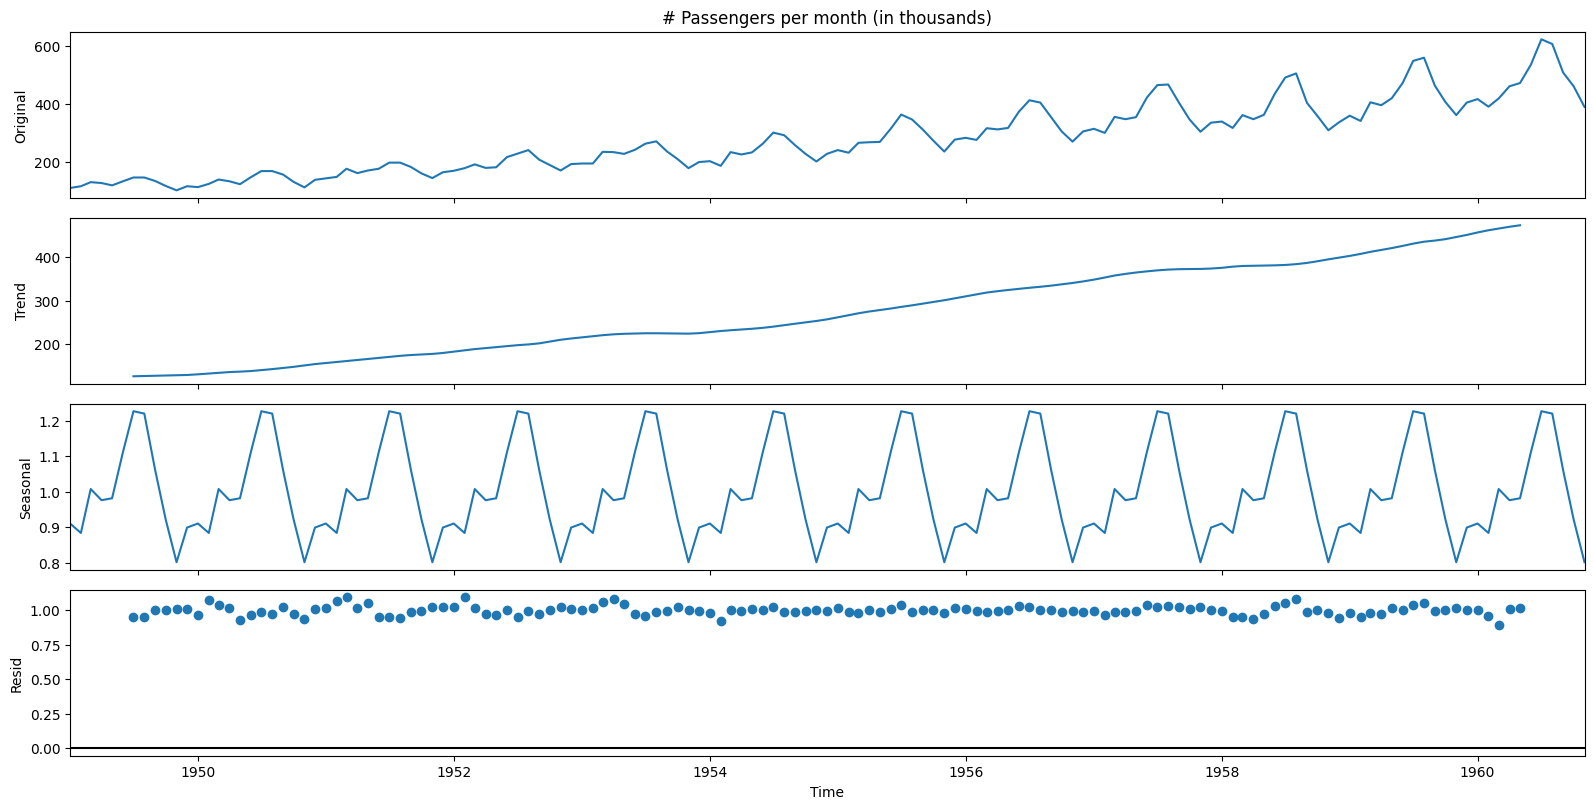

In [7]:
fig = decomposition.plot()
fig.axes[0].set_title("# Passengers per month (in thousands)")
fig.axes[0].set_ylabel("Original")
fig.axes[3].set_xlabel("Time")
plt.show()

And, it also allows to directly access the components values

In [8]:
decomposition.trend.head(10)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01           NaN
1949-07-01    126.791667
1949-08-01    127.250000
1949-09-01    127.958333
1949-10-01    128.583333
Name: trend, dtype: float64

In [9]:
decomposition.seasonal.head(10)

Month
1949-01-01    0.910347
1949-02-01    0.883739
1949-03-01    1.007496
1949-04-01    0.976032
1949-05-01    0.981504
1949-06-01    1.111376
1949-07-01    1.226713
1949-08-01    1.220068
1949-09-01    1.060628
1949-10-01    0.921876
Name: seasonal, dtype: float64

In [10]:
decomposition.resid.head(10)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    0.951542
1949-08-01    0.953279
1949-09-01    1.002091
1949-10-01    1.003899
Name: resid, dtype: float64

**Extra tip:** the same way that a rolling `std` can help on grasping the variance behavior, changing this to `mean` can help on grasping the trend (although `seasonal_decompose` handles this as well).

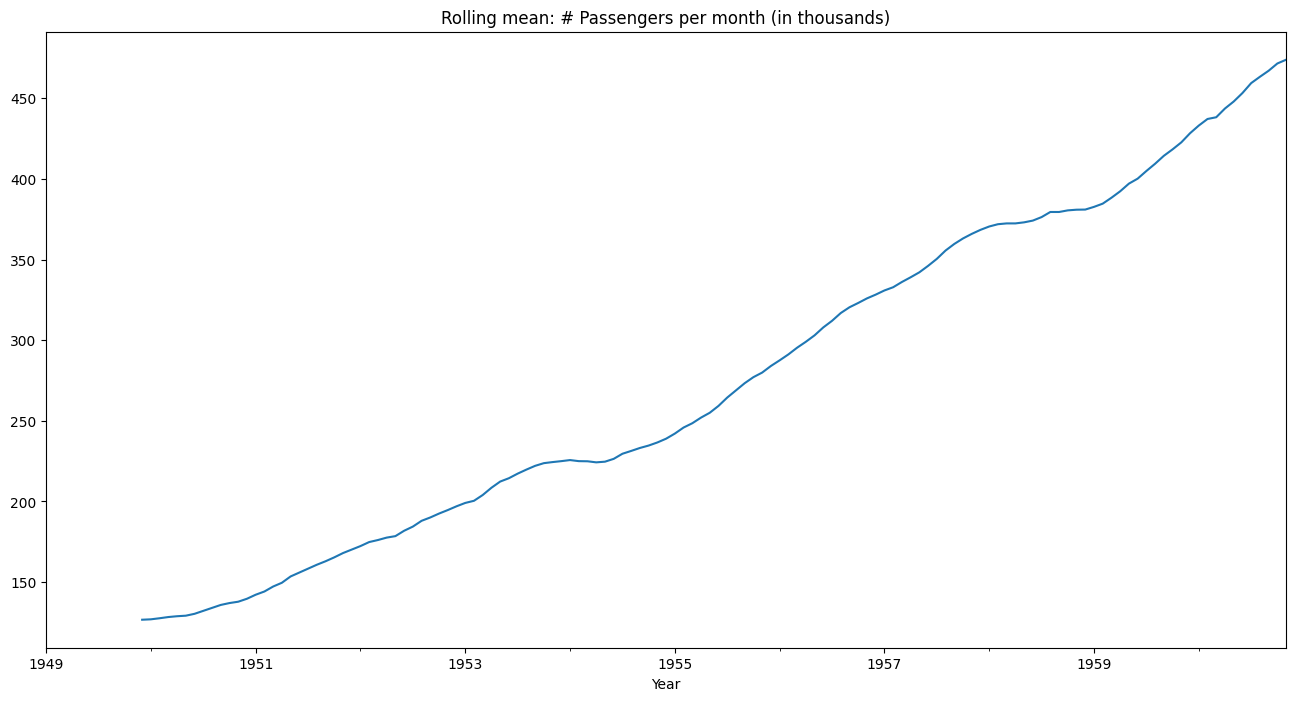

In [45]:
airlines.rolling(12).mean().plot()
plt.xlabel("Year")
plt.title("Rolling mean: # Passengers per month (in thousands)")
plt.show()

### Let's see some more examples
Let's consider two other *mysterious* datasets: `mysterious_data_1` and `mysterious_data_2`.

**WARNING**: if you wish to keep the mystery, run the next cell without reading it :)

In [12]:
from datetime import datetime

mysterious_data_1 = load_electricity_consumption_series()["consumption"]
mysterious_data_2 = pd.Series([gauss(0.0, 1.0) for i in range(1000)])
mysterious_data_2.name = "White noise"
mysterious_data_2.index = pd.date_range(
    datetime(1971, 12, 25, hour=12, minute=0), periods=1000, freq="3d"
)

Text(0.5, 1.0, 'Mysterious variable 1, monthly')

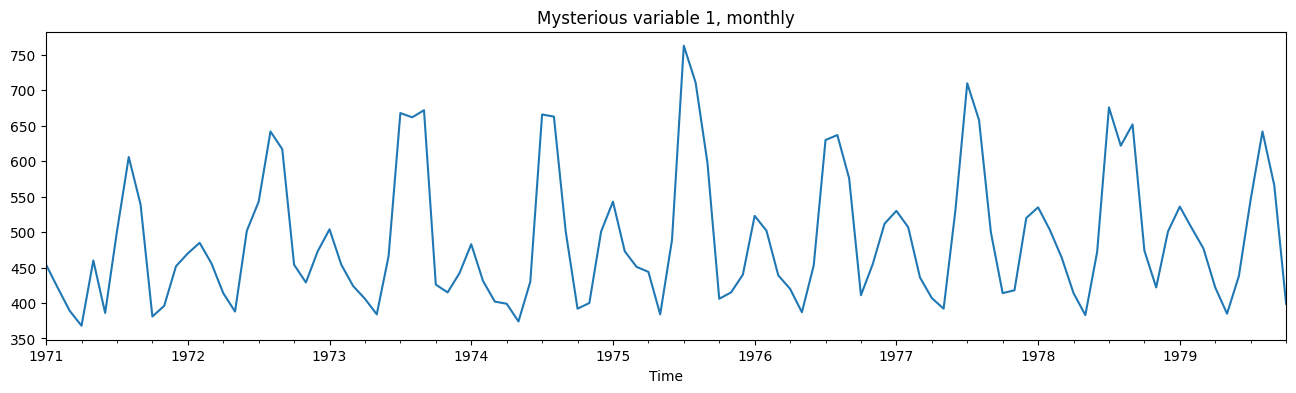

In [13]:
mysterious_data_1.plot(figsize=(16, 4))
plt.xlabel("Time")
plt.title("Mysterious variable 1, monthly")

Text(0.5, 1.0, 'Mysterious variable 2, monthly')

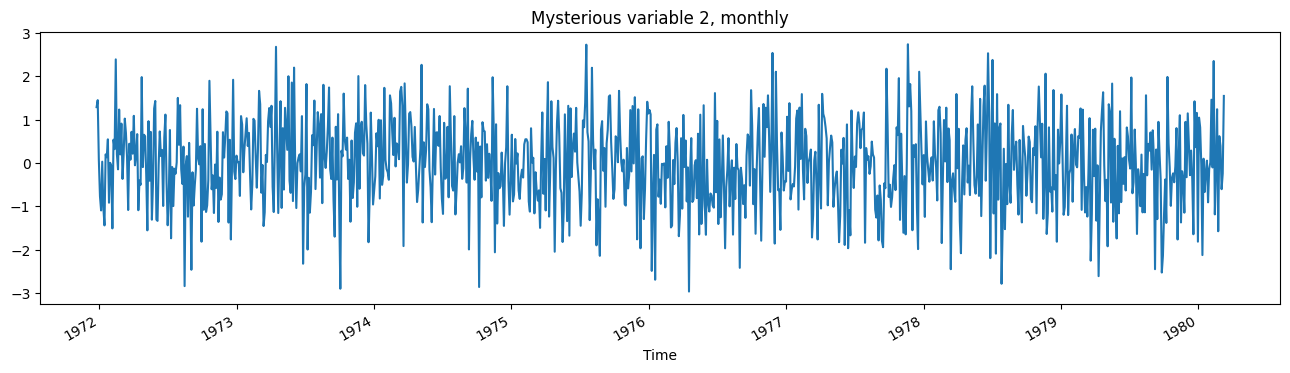

In [14]:
mysterious_data_2.plot(figsize=(16, 4))
plt.xlabel("Time")
plt.title("Mysterious variable 2, monthly")

Just from comparing these plots, there is already a visual clue that we seem to have more structure in the first dataset than in the second.

We can continue to search for structure by decomposing the signal, as you've learned in the previous BLU. Since the variance does not seem to increase throughout time in both cases, we will consider an `additive` decomposition model.

##### Mysterious data 1 

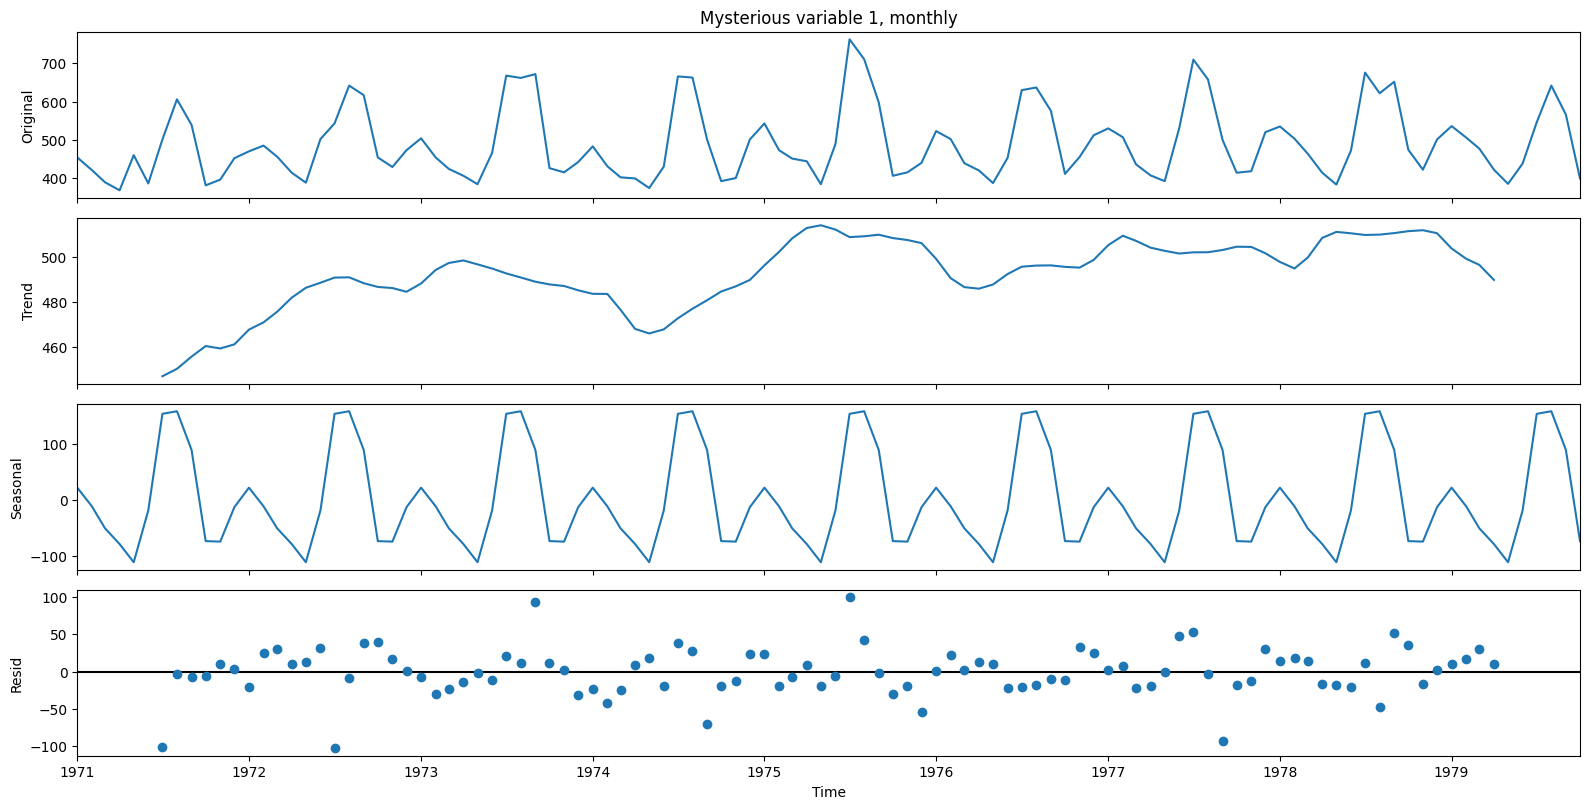

In [15]:
decomposition = seasonal_decompose(mysterious_data_1, model="additive")
fig = decomposition.plot()
fig.axes[0].set_title("Mysterious variable 1, monthly")
fig.axes[0].set_ylabel("Original")
fig.axes[3].set_xlabel("Time")
plt.show()

##### Mysterious data 2

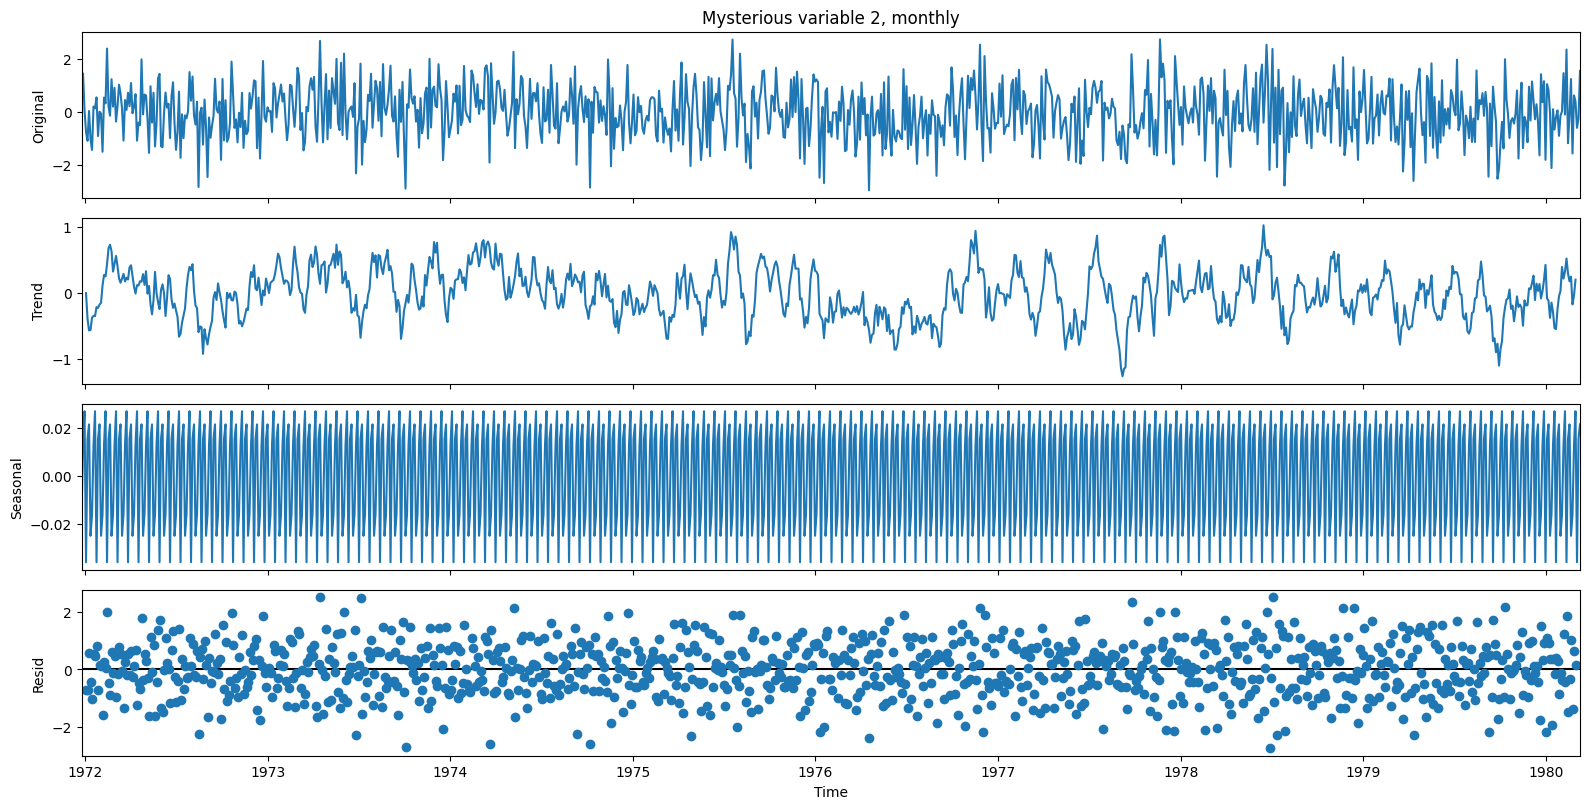

In [16]:
decomposition = seasonal_decompose(mysterious_data_2, model="additive")
fig = decomposition.plot()
fig.axes[0].set_title("Mysterious variable 2, monthly")
fig.axes[0].set_ylabel("Original")
fig.axes[3].set_xlabel("Time")
plt.show()

Well... **_`mysterious_data_2`_** seems more mysterious than **_`mysterious_data_1`_**, but this is all very subjective and possibly misleading. Maybe we have a more objective way to look for structure? 

## 2. Autocorrelation

In the previous BLU we manually checked the correlation for each lagged version of the timeseries. But I bet you didn't know  that we were actually looking at the ACF, which stands for Autocorrelation Function! Here, we're going to learn about ACF, its cousin PACF (**Partial** Autocorrelation Function) and how to calculate them more expeditely.

### 2.1 ACF

The idea, in plain English, is very simple: _"for a given timeseries, how correlated is each datapoint, to the datapoints lagged x periods?"_

#### 2.1.1 Calculating ACF by hand

Original dataset: 

In [17]:
mysterious_data_1.head()

month
1971-01-01    454.0
1971-02-01    421.0
1971-03-01    389.0
1971-04-01    368.0
1971-05-01    460.0
Name: consumption, dtype: float64

Dataset, lagged by 1 period (a concept already introduced in the previous BLU):

In [18]:
mystery_lag_1 = mysterious_data_1.shift(1)
mystery_lag_1.head()

month
1971-01-01      NaN
1971-02-01    454.0
1971-03-01    421.0
1971-04-01    389.0
1971-05-01    368.0
Name: consumption, dtype: float64

So... the data that was at `1971-01-01` is now at `1971-02-01`, and so on and so forth. Fancy. 

How correlated are `mystery_data_1` and `mystery_lag_1`? 

In [19]:
mysterious_data_1.corr(mystery_lag_1)

0.5262475690238556

Ok... how about if we lag it two times? 

In [20]:
mysterious_data_1.corr(mysterious_data_1.shift(2))

-0.14550472700327163

Negatively correlated...

Let's get a bunch of these, testing for various lags:

In [21]:
corrs = {}
for lag in range(40):
    corrs[lag] = mysterious_data_1.corr(mysterious_data_1.shift(lag))

In [22]:
pd.Series(corrs).head()

0    1.000000
1    0.526248
2   -0.145505
3   -0.490220
4   -0.334527
dtype: float64

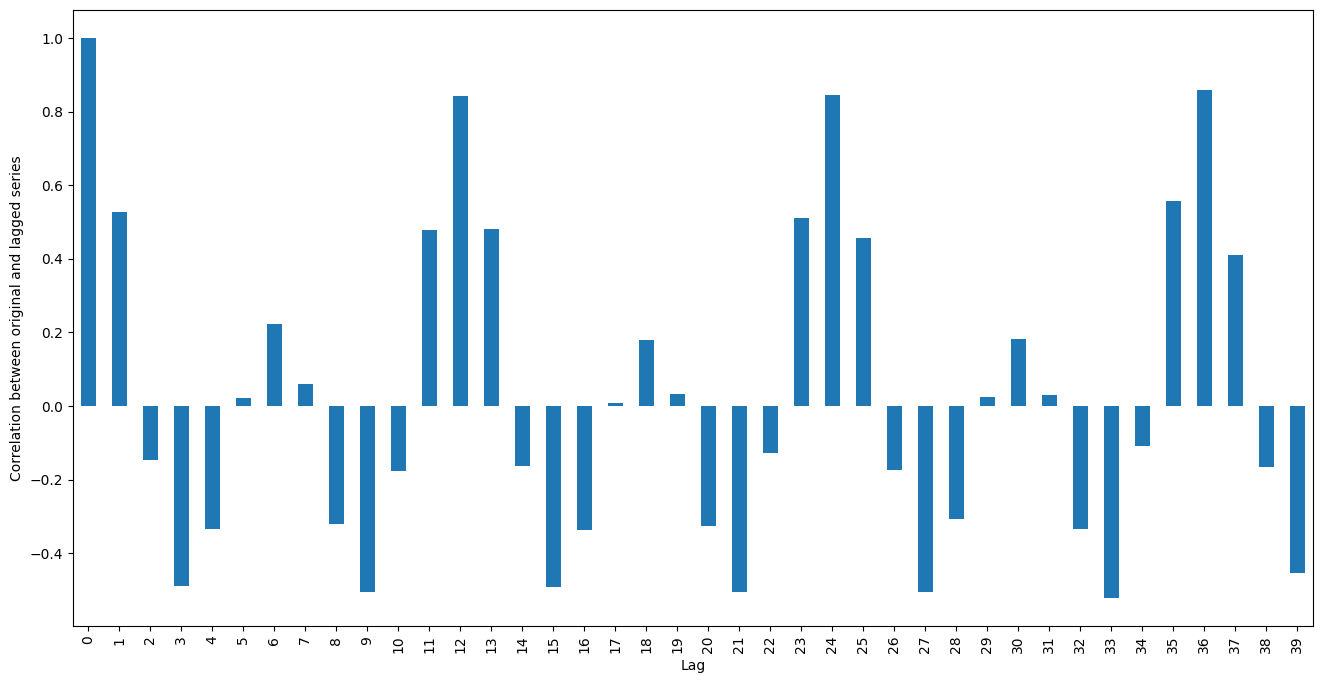

In [23]:
pd.Series(corrs).plot(kind="bar")
plt.xlabel("Lag")
plt.ylabel("Correlation between original and lagged series")
plt.show();

Wooow! We can see the structure! Every 12 months (year!) we get a really high correlation. And there is an up and down pattern which may be related to the yearly seasons (spring and its friends). Cool bananas. 

#### 2.1.2 ACF with stats model

statsmodel actually comes with functions to calculate and plot ACF (I bet you're thinking _"Wow, ACF must be really useful!"_).

But, there's more! It also gives you something super useful: pre-calculated confidence intervals which tell you how significant the auto-correlation is (a.k.a. how statistically reliable the ACF values are).

In [24]:
# I'm allowed to import stuff in the middle of the notebook, and you aren't. Muahahaha!
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [25]:
acf(mysterious_data_1)

array([ 1.        ,  0.52351648, -0.14388441, -0.47602432, -0.32189455,
        0.02128615,  0.20982187,  0.05729749, -0.29908263, -0.47353522,
       -0.16368264,  0.44064126,  0.77413446,  0.44222172, -0.14789621,
       -0.44085934, -0.29582641,  0.00320722,  0.15036108,  0.02568834,
       -0.27648917])

Well that's what we just saw by hand. And the plot? 

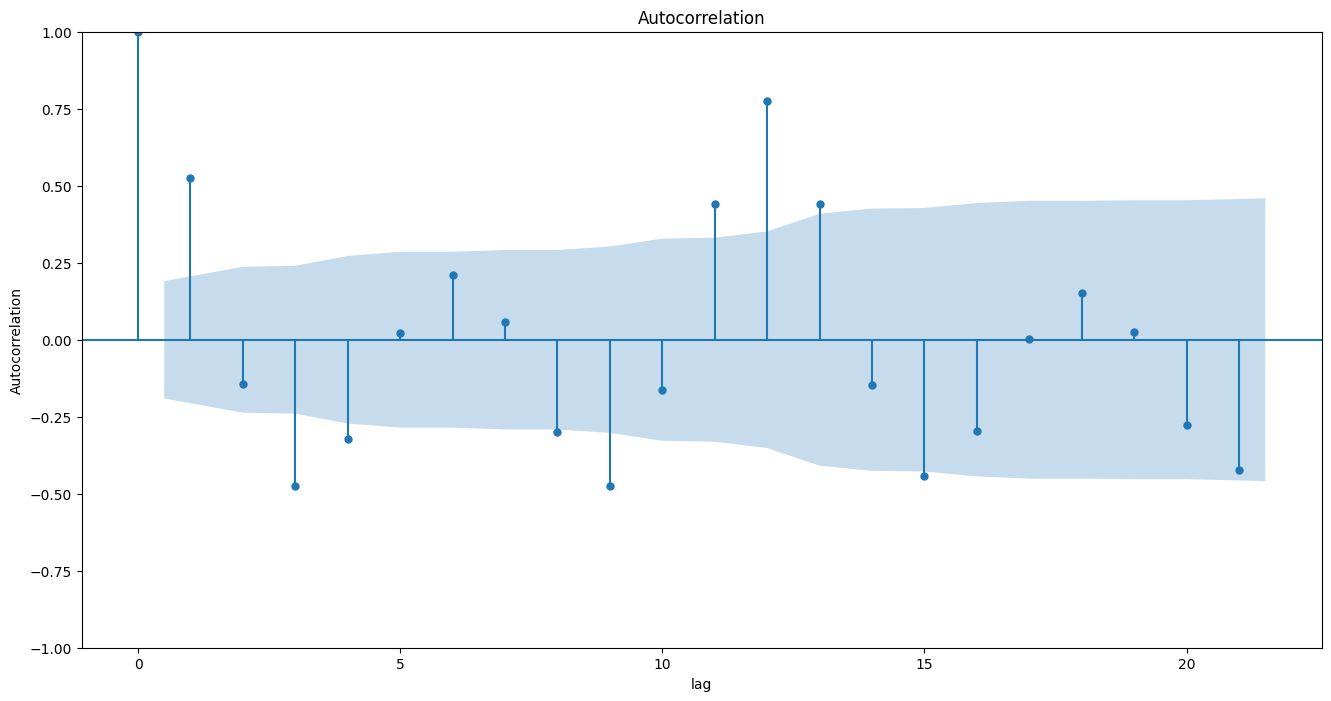

In [26]:
plot_acf(mysterious_data_1, alpha=0.05)
plt.xlabel("lag")
plt.ylabel("Autocorrelation")
plt.show()

Preeettyyyyy.... Just by looking at this plot, we can tell that there is some clear seasonal behavior, and that it is quite significant around lag 12. 

On the other hand, the shaded area is the confidence interval we mentioned before and it illustrates the uncertainty behind the ACF estimates. It always assumes a certain degree of confidence: for example, the parameter `alpha=0.05`, given to `plot_acf` before, is equivalent to assuming a 95% confidence.

To make this even clearer: statsmodel is 95% confident that the ACF value for lag 1 is between the interval $0.523 \pm0.2$ (yes, I rounded the numbers a bit, I'm just that lazy o_o)

But remember! If you're 95% confident, then you're going to be wrong once every 20 times, so take the confidence interval with that pinch of salt.

But what if we want to see more lags? Statsmodels' got you covered:

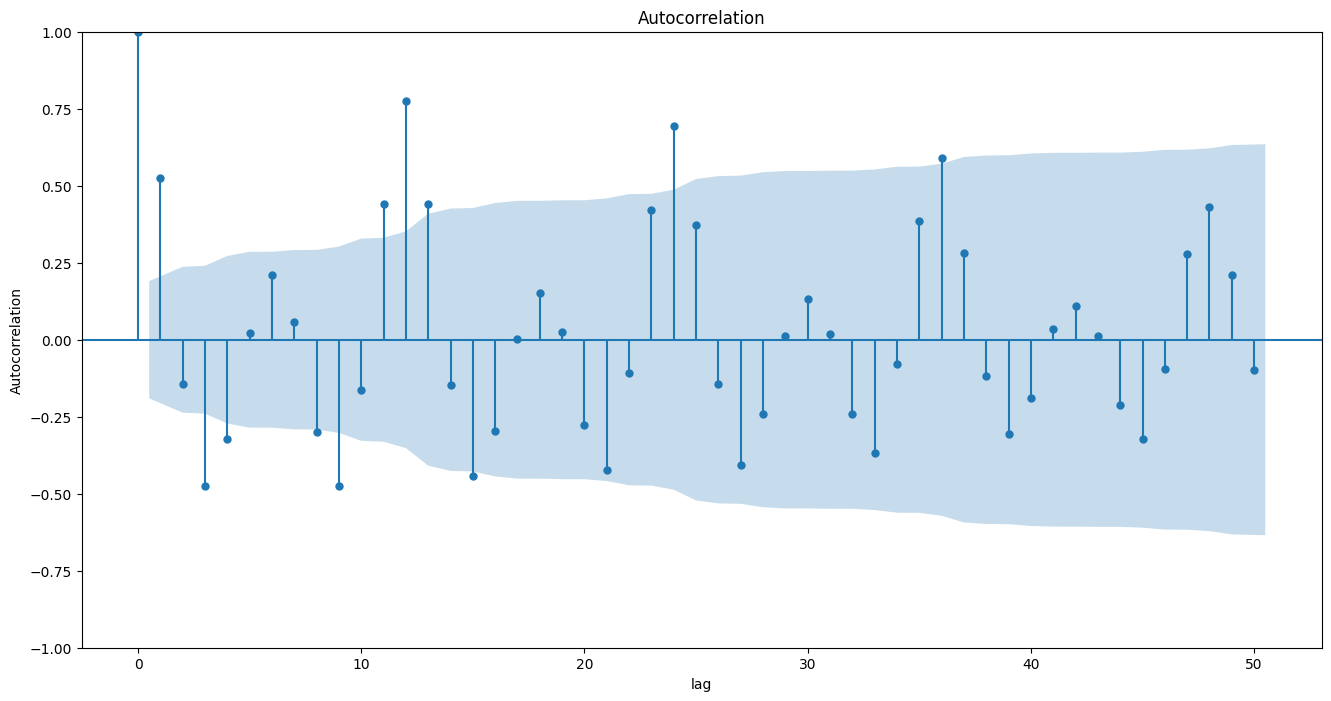

In [27]:
plot_acf(mysterious_data_1, alpha=0.05, lags=50)
plt.xlabel("lag")
plt.ylabel("Autocorrelation")
plt.show()

##### What happens if there is no structure? 

So, we said this helped find structure. What happens if we apply this to the sneaky looking `mysterious_data_2`? 

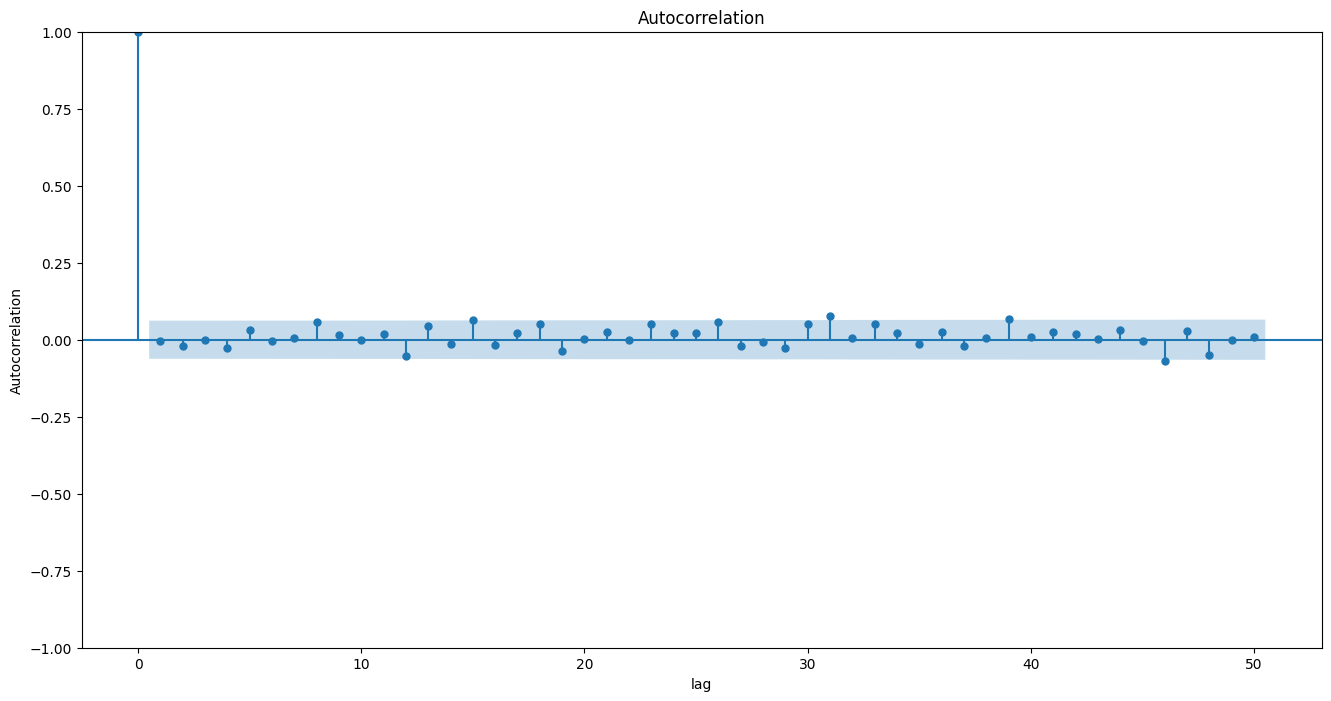

In [28]:
plot_acf(mysterious_data_2, alpha=0.05, lags=50)
plt.xlabel("lag")
plt.ylabel("Autocorrelation")
plt.show()

That, ladies and gentlemen, is how you know that noise... is noise :)

### 2.2 PACF

As mentioned in the intro to section 2, [PACF](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula/129374#129374) stands for Partial Autocorrelation Function.

To illustrate what PACF is used for, I'm going to plot the **old ACF** for `mysterious_data_1`: 

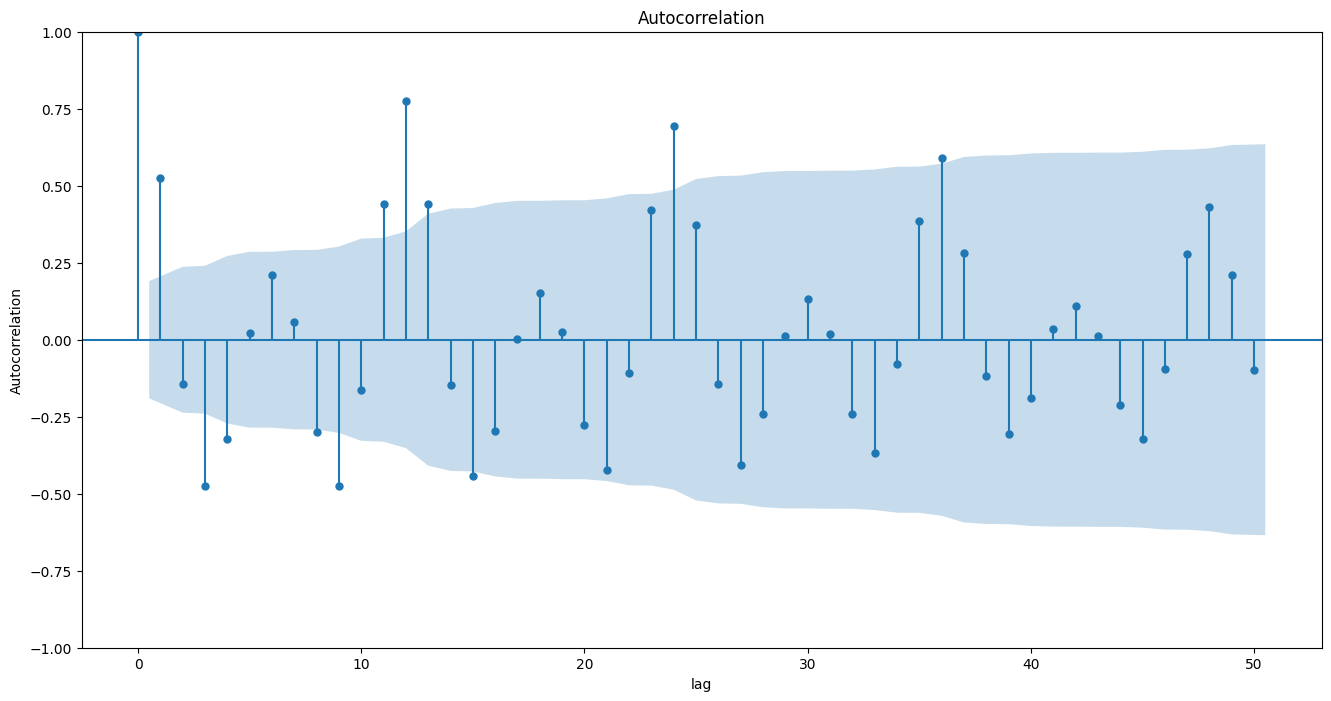

In [29]:
plot_acf(mysterious_data_1, alpha=0.05, lags=50)
plt.xlabel("lag")
plt.ylabel("Autocorrelation")
plt.show()

Again, we can see that lag 12 has a high auto-correlation. But so does lag 24. And lag 36.

Now imagine you walk into a room and share these results with your boss:
> _"I've found something! The patterm seems to happen every year, and every two years, and every 3 years, and every 4 years!"_

You might rightfully be laughed at, right? Because the results, as your phrasing suggested, are kind of "recycling" auto-correlation from the previous year. 

Moreover, this remark can be further expanded: any lag can influence its successor (in multiples). Meaning that the lag 1 correlation may be impacting all the other lags (as every integer is a multiple of 1), lag 2 can be impacting lags 4, 6, 8,etc., lag 3 the lags 6, 9, 12 etc., and I think that by now you already get the gist of it.

Ideally, we'd want to remove the autocorrelation that we've already accounted for, and plot just the "unaccounted for" stuff. And that, dear student, is what the PACF is for. 

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf

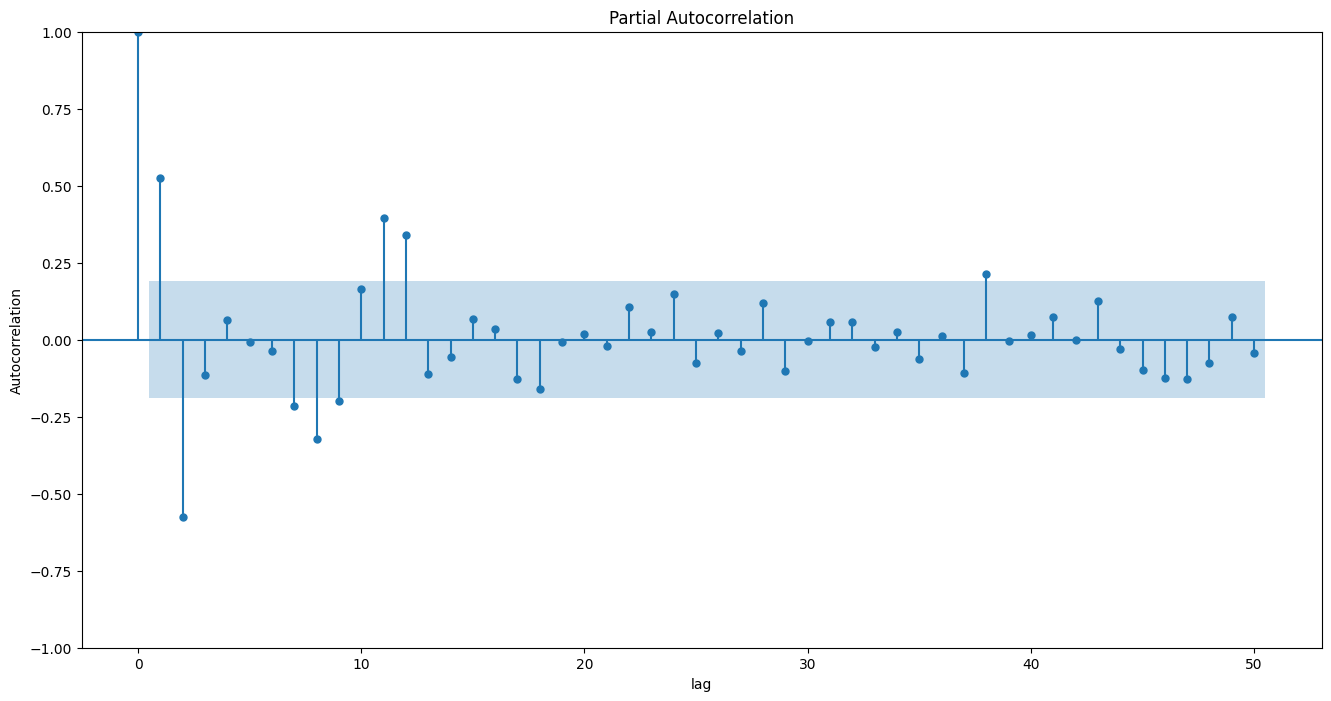

In [31]:
plot_pacf(mysterious_data_1, alpha=0.05, lags=50, method="ywm")
plt.xlabel("lag")
plt.ylabel("Autocorrelation")
plt.show()

Ooops! It seems like we've got a warning from _statsmodels_. Also, the values of the PACF are outside the [-1,1] bounds, which is **impossible**. This is a well known numerical problem that can occur due to the approximations in the calculations. A quick way to solve this warning is to change the underlying method to calculate the PACF:

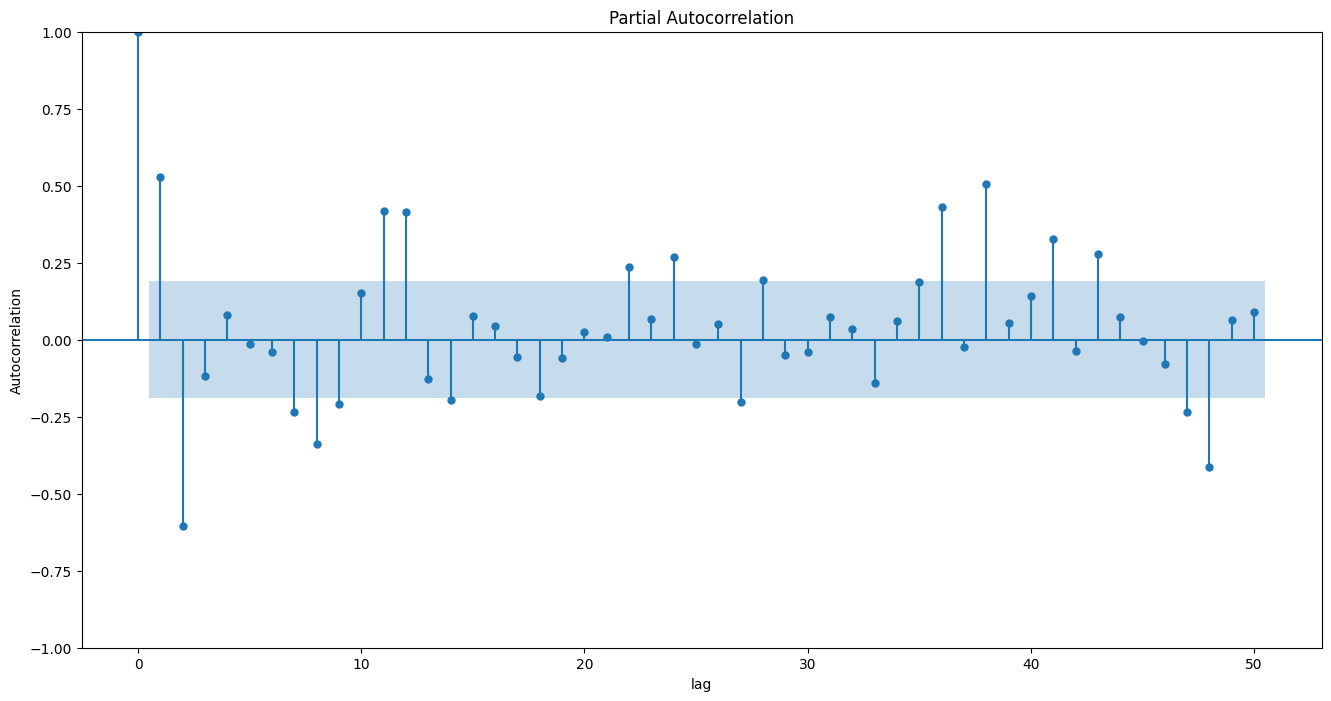

In [32]:
plot_pacf(mysterious_data_1, alpha=0.05, lags=50, method="ols")
plt.xlabel("lag")
plt.ylabel("Autocorrelation")
plt.show()

<img src="images/pacf_cowell2.jpg">

Now it makes sense. The PACF is similar to the ACF but without the repeating correlation lags. So basically, the PACF is showing us the ACF but penalizing seasonality-related autocorrelation. Why do we want this you ask? Well, because we already know that there is seasonality with lag 12.

Thanks to the PACF we are now able to find more possible correlations, which were camouflaged in the ACF by the effect of seasonality. On the PACF we can see much more interesting lags, like lag 2 for example with -0.6 autocorrelation, which was only -0.2 on the ACF. This shows that it was not only the lag 12 correlation which was being "recycled".

In this section we briefly introduced the ACF and PAC, but if you want to take a deeper look at [the maths of it](https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula/129374#129374), feel free!

## 3. Stationarity

The concept of autocorrelation is essential for modelling time series, but at least as important is understanding what stationarity is.

For the math nerds: https://en.wikipedia.org/wiki/Stationary_process#Weak_or_wide-sense_stationarity

For the others, a brief explanation:

> **_"A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time."_**

Stationarity is a holy grail in timeseries, especially if you are using the type of models we will show you next. If a process is stationary, then you can make cool predictions. Thus, it would make totally sense if we could (and we will!) transform our timeseries until they are stationary.

First, let's look at a clearly non-stationary timeseries, our old friend airlines dataset:

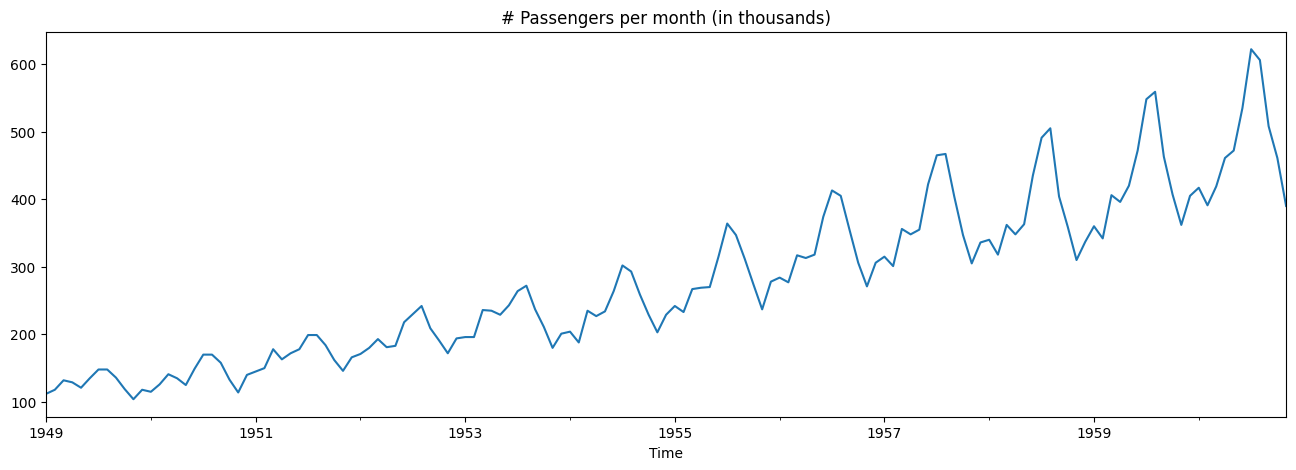

In [33]:
airlines.plot(figsize=(16, 5))
plt.xlabel("Time")
plt.title("# Passengers per month (in thousands)")
plt.show()

#### Is the mean constant over time? 
Nop. 

#### Is the variance constant over time? 
Oh hell no.

#### Is the auto-correlation constant over time? 
Probably not...

Let's beat this timeseries into submission until it becomes stationary! 

## 3.1 Stabilize Variance

First, we should stabilize the variance so that it is approximately constant over time. The most common way to do that is to apply the log transform, which is just a special case of the [box-cox transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html). For those interested, it's definitely worth exploring further. So let's see how log changes our timeseries.

In [34]:
airlines_logged = airlines.map(np.log)

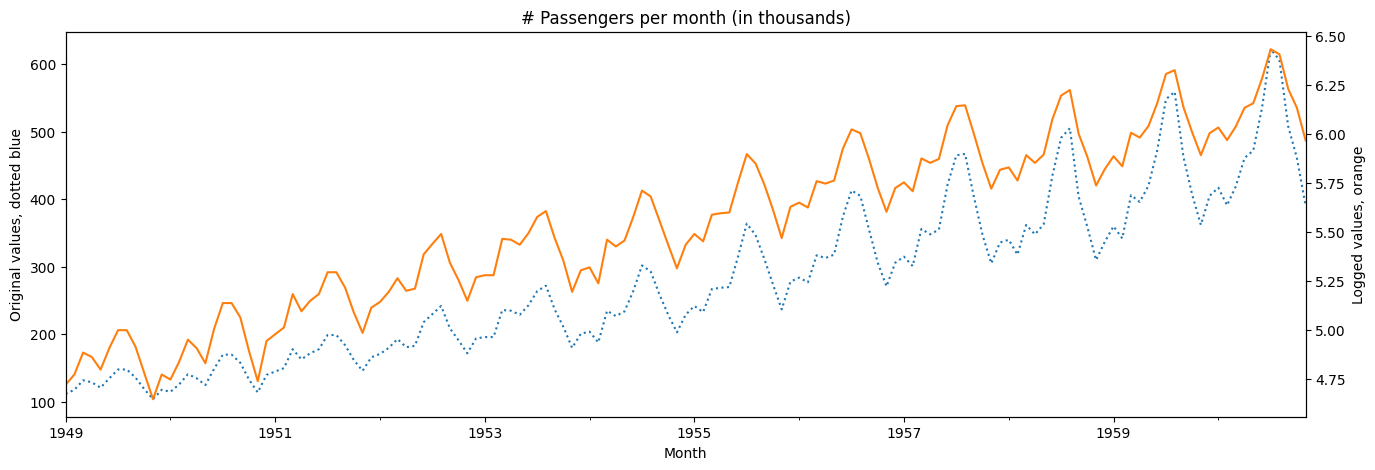

In [35]:
airlines.plot(ls=":")
plt.ylabel("Original values, dotted blue")
airlines_logged.plot(figsize=(16, 5), secondary_y=True)
plt.ylabel("Logged values, orange")
plt.title("# Passengers per month (in thousands)")
plt.show()

And now, let's again plot a rolling standard deviation so that we can have a better sense of how variance evolves:

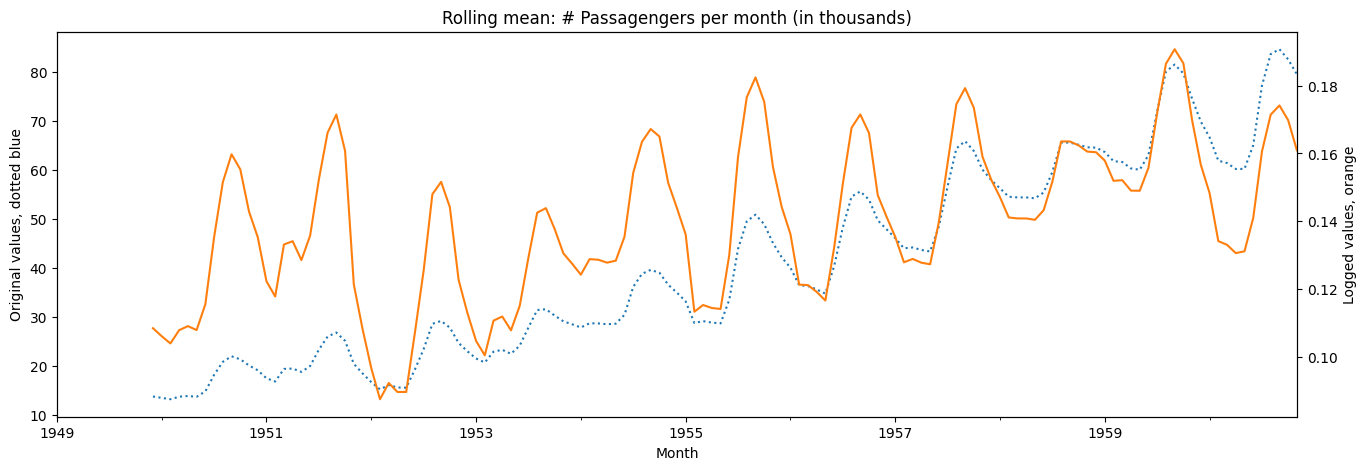

In [36]:
airlines.rolling(12).std().plot(ls=":")
plt.ylabel("Original values, dotted blue")
airlines_logged.rolling(12).std().plot(figsize=(16, 5), secondary_y=True)
plt.ylabel("Logged values, orange")
plt.title("Rolling mean: # Passagengers per month (in thousands)")
plt.show()

Notice how the variance in the original timeseries keeps growing, while this trend is greatly mitigated on our logged timeseries!

## 3.2 Removing trend 

The next step is to remove the trend, so that the means of the timeseries is approximatelly constant over time. A trivial way to remove the trend is to take the lag 1, and subtract it. In other words, instead of using the series, we will use the difference beween consecutive observations. 

Difference, you say? difference... Ah! [Diff!](https://pandas.pydata.org/pandas-docs/version/0.17/generated/pandas.Series.diff.html)

In [37]:
airlines_logged_diff = airlines_logged.diff()

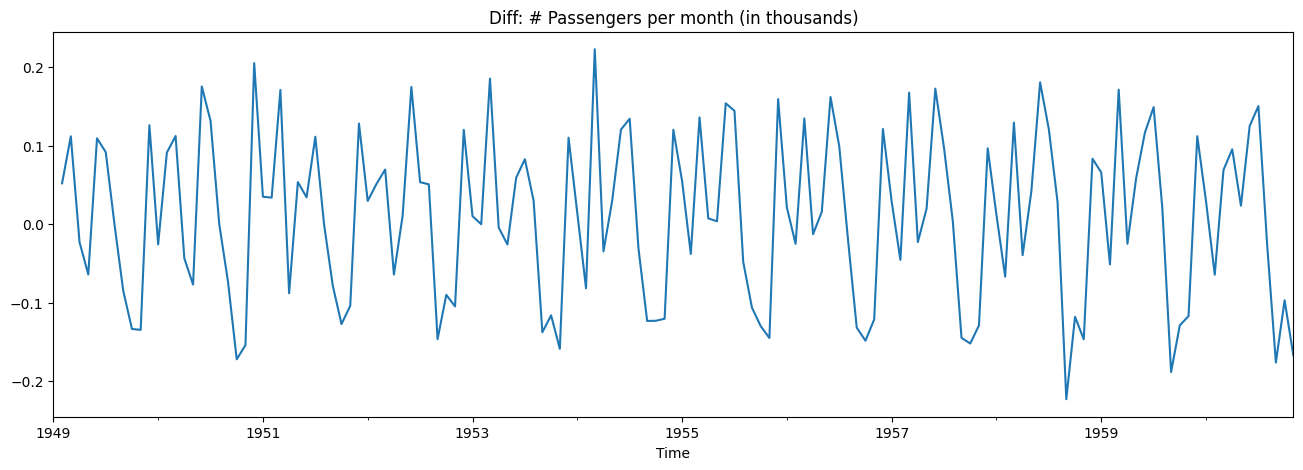

In [38]:
airlines_logged_diff.plot(figsize=(16, 5))
plt.xlabel("Time")
plt.title("Diff: # Passengers per month (in thousands)")
plt.show()

Hmm... mean looks constant over time, variance seems constant over time... looks like we managed! 

Note: it's advised to do the log transform first, and then the diff. The reason is that the diff has a tendency to place results at zero, which will prove problematic with the log transform. 

## 3.3 Other methods 

This was clearly an easy-to-make-stationary timeseries. Most cases, in fact, require a lot more work. There are approaches such as removing a moving average that are more powerful, and tend to work quite well. 

However, remember this: whatever transformation you do to your timeseries in your attempt to make it stationary, you should be able to reverse later. If your boss asks you 
> _"How many passengers are we going to have next sunday?"_


Answering this won't get you far: 
> _"On next sunday, I predict a logged diff of -0.23."_

So whenever you are transforming your timeseries, you need to keep these transformations reversible, and the more complex the transformation, the more complex it is to invert. 

## 3.4 Evaluating stationarity 

Is it stationary? It... "looks stationary". 

But, as with so many things in life, when you need to quantify them, generally you'll find that [there is a way](https://i.imgflip.com/2a3kei.jpg). 

For that, we use the **[Dickey-Fuller test](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller)**: 

In [39]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

The Dickey-Fuller test has the null hypothesis that the [Unit Root](https://en.wikipedia.org/wiki/Unit_root) is present. The details of this are interesting yet out of scope, but suffice it to say for our purposes that if the unit root isn't present, the timeseries can be assumed to be stationary. 

So, for the time being, "_Unit Root is bad_ ", and "_no Unit Root is good_ ". Only if the p-value is below a critical size do we have statistical evidence to reject the unit root. Thus, there is statistical evidence that our series is stationary.
 
 So... we want a low p-value. Got that? Great. 

So let's just pass it our series... 

In [40]:
try:
    adfuller(airlines_logged_diff)
except Exception as e:
    print("NEIN! And here is why: %s" % e)

NEIN! And here is why: exog contains inf or nans


Ah damn it. The reason why we have this try-catch is because you're gonna run into this at some point: 

> We forgot to get rid of our missing data. The first point, remember? 

In [41]:
airlines_logged_diff.head(3)

Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
Name: thousands of passengers, dtype: float64

Trying again without the missing datapoint:

In [42]:
adfstat, pvalue, usedlag, nobs, critvalues, icbest = adfuller(
    airlines_logged_diff.dropna()
)

Ok, I know, so many returns. It's worth taking a look at [the documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller), but for our purposes, we're going to use it in a ridiculously simple way: 

In [43]:
print("Statistic: %0.02f" % adfstat)
print("pvalue:    %0.03f" % pvalue)

Statistic: -2.71
pvalue:    0.073


The p-value is low, but not as low as we normally like it to be (ideally < 0.05). We can't reject that we have unit root at a 95% confidence interval, which is a good rule of thumb. But since this is just an example, we can leave as it is. 

If we really wanted to have a more stationary time series we could use more sophisticated ways to get rid of the trend (subtracting the rolling mean) or even using `diff` again. But do be careful with the diffs, it's like salt, you want just enough, too much ruins the dish. 

So that's it for the basics on preparing your time series for modelling. On the next notebooks you will find out that some of this work is already done for you in certain libraries, but it's always fundamental that you have an idea of what's going on behind the scenes.

Make sure to check this [article](https://twitterdev.github.io/do_more_with_twitter_data/timeseries.html#timeseries) from Twitter's `Do More with Twitter Data`, as it describes an excelent example of making time series analysis.